<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/notebooks/two4two_model_and_data_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from PIL import Image

torch.backends.cudnn.benchmark = True

In [2]:
torch.__version__

'2.4.0+cpu'

# Params

In [3]:
CLASSES = ['Healthy', 'OC Degeneration']
modeltype = 'mobilenet'
ds = 'sick_ones_bendbias'

# Setup and Load Datasets

In [4]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [5]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                         file_name="two4two_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

File already exists at: /content/data\two4two_datasets.tar.gz
File extracted to: /content/data


WindowsPath('/content/data/two4two_datasets')

In [6]:
ds_dir = data_dir / ds
ds_dir

WindowsPath('/content/data/two4two_datasets/sick_ones_bendbias')

In [7]:
# load datasets and dataloaders for pytorch processing
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

# Model Loading and Evaluation





In [8]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [9]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [10]:
checkpoint_path = download_file(url='https://uni-bielefeld.sciebo.de/s/5uQFFsAprXT05in/download',
                                file_name='best_model.pth',
                                cache_dir='/content/model/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=False)
checkpoint_path

File already exists at: /content/model/mobilenetv2_checkpoint\best_model.pth


WindowsPath('/content/model/mobilenetv2_checkpoint/best_model.pth')

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Evaluate Model

In [ ]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=True,
                         checkpoint_path=checkpoint_path)
model.to(device)

#evaluate_model(model, train_dataloader, criterion, device)
#evaluate_model(model, val_dataloader, criterion, device)
#evaluate_model(model, test_dataloader, criterion, device)

<ipython-input-8-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from: /content/model/mobilenetv2_checkpoint/best_model.pth
Evaluation Loss: 0.2447, Evaluation Accuracy: 0.8924
Evaluation Loss: 0.2928, Evaluation Accuracy: 0.8710
Evaluation Loss: 0.2911, Evaluation Accuracy: 0.8680


(0.2910529184848704, 0.868)

In [12]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):

    model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    if checkpoint_path:
        # Load the checkpoint for CPU usage
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model

model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=True,
                         checkpoint_path=checkpoint_path)
model.to(device)



Loaded checkpoint from: \content\model\mobilenetv2_checkpoint\best_model.pth


C:\Users\hp 840\AppData\Local\Temp\ipykernel_18004\1438251666.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
import torch
from model import Model
from explainers import saliency_explainer, intgrad_explainer
from agg_explainers import AGGmean_explainer
from utils import prepare_input
from plot import plot_explanations
from torchvision import transforms
from utils import prepare_input

from pathlib import Path
from torchvision.models import resnet50, ResNet50_Weights

extracted_dir = Path(data_dir) / "two4two_datasets"

# Localiser dynamiquement une image
image_path = next(extracted_dir.rglob("*.png"))  # Récupère le premier fichier PNG trouvé
print(f"Image path: {image_path}")


_, prepared_input = prepare_input(str(image_path))
prepared_input = prepared_input.float()

transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()




original_image, prepared_input = prepare_input(image_path, transforms=transforms, grayscale=False)
prepared_input = prepared_input.to(device)
prepared_input.requires_grad = True

Image path: \content\data\two4two_datasets\two4two_datasets\sick_ones_bendbias\test\000773b6-93f9-4a21-bbd5-7e4af0c31f74.png


In [33]:
from explainers import (
    saliency_explainer,
    intgrad_explainer,
    smoothgrad_explainer,
    vargrad_explainer,
    guidedbackprop_explainer
)
from agg_explainers import AGGopt_explainer

pytorch_model = load_mobilenetv2(num_classes=2, pretrained=True)  
wrapped_model = Model(model=pytorch_model, device=device)

# Initialisation des explainers
saliency = saliency_explainer(wrapped_model)
intgrad = intgrad_explainer(wrapped_model)
smoothgrad = smoothgrad_explainer(wrapped_model)
vargrad = vargrad_explainer(wrapped_model)
guidedbp = guidedbackprop_explainer(wrapped_model)

saliency_kwargs = {"abs": True}
intgrad_kwargs = {"baselines": torch.zeros_like(prepared_input)}
smoothgrad_kwargs = {}
vargrad_kwargs = {}

# Liste des explainers et leurs arguments
explainers = [saliency, intgrad, smoothgrad, vargrad]
explainers_kwargs = [saliency_kwargs, intgrad_kwargs, smoothgrad_kwargs, vargrad_kwargs]

agg_opt = AGGopt_explainer(wrapped_model, explainers, explainers_kwargs, baseline=None, segments=None)


In [35]:
target_class = 1
explanation_saliency = saliency.explain(prepared_input, target=target_class)
print(f"Saliency Explanation keys: {explanation_saliency.keys()}")

explanation_intgrad = intgrad.explain(prepared_input, target=target_class)
print(f"Integrated Gradients Explanation keys: {explanation_intgrad.keys()}")

explanation_smoothgrad = smoothgrad.explain(prepared_input, target=target_class)
print(f"SmoothGrad Explanation keys: {explanation_smoothgrad.keys()}")

explanation_vargrad = vargrad.explain(prepared_input, target=target_class)
print(f"VarGrad Explanation keys: {explanation_vargrad.keys()}")


explanation_aggopt = agg_opt.explain(prepared_input, target=target_class)
print(f"AGGopt Explanation keys: {explanation_aggopt.keys()}")

Saliency Explanation keys: dict_keys(['saliency'])
Integrated Gradients Explanation keys: dict_keys(['IntGrad'])
SmoothGrad Explanation keys: dict_keys(['SmoothGrad'])
VarGrad Explanation keys: dict_keys(['VarGrad'])


c:\Users\hp 840\Downloads\main - Copie - Copie\main\src\base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


AGGopt Explanation keys: dict_keys(['AGGopt'])


In [36]:
def normalize_explanation(explanation):
    explanation -= explanation.min()
    explanation /= explanation.max()
    return explanation

# Réduction et normalisation des explications

saliency_map = normalize_explanation(explanation_saliency["saliency"])
intgrad_map = normalize_explanation(explanation_intgrad["IntGrad"])
smoothgrad_map = normalize_explanation(explanation_smoothgrad["SmoothGrad"])
vargrad_map = normalize_explanation(explanation_vargrad["VarGrad"])
aggopt_map = normalize_explanation(explanation_aggopt["AGGopt"])


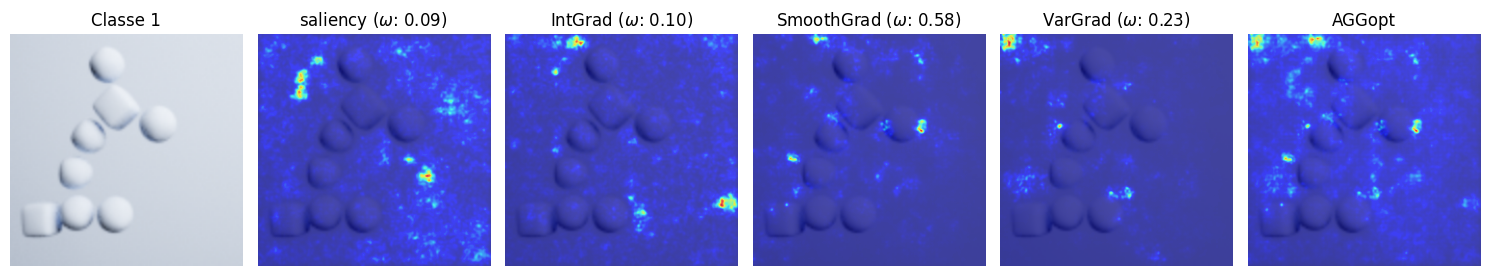

In [37]:
from plot import plot_explanations, plot_agg_explanations

# plot_explanations(
#     inputs=prepared_input.detach(),
#     explanations={
#         "Saliency": saliency_map,
#         "Integrated Gradients": intgrad_map,
#         "SmoothGrad": smoothgrad_map,
#         "VarGrad": vargrad_map,
#         "AGGopt": aggopt_map,
#     },
#     label=f"Classe {target_class}"
# )


plot_agg_explanations(prepared_input.detach(), agg_opt.explanations, label="Classe 1", overlay=True, weights=agg_opt.get_weights(), figsize=(15, 10))


In [38]:
import numpy as np
import torch
from torchvision.transforms import GaussianBlur

def normalize_explanation(explanation):
    explanation = np.abs(explanation)
    mean_val = np.mean(explanation) + 1e-8  # Avoid division by zero
    return explanation / mean_val


def compute_infidelity(
    model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=30
):
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])

    gaussian_blur = GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 1.0))  # Adjust blur for subtler effects
    infidelity_scores = []

    for i in range(num_samples):
        # Generate perturbation mask
        mask = (torch.rand_like(input_image) < 0.5).float()

        perturbed_image = mask * baseline_image + (1 - mask) * input_image
        perturbed_image = perturbed_image.clamp(0, 1)

        # Compute model predictions
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()

        # Normalize explanation's contribution
        masked_explanation_sum = (mask * explanation).sum().item()
        masked_explanation_sum /= (explanation.sum().item() + 1e-6)

        prediction_difference = original_pred - perturbed_pred


        # Adjust weighting for prediction differences
        relative_weight = np.exp(-np.abs(prediction_difference))
        infidelity_score = relative_weight * (masked_explanation_sum - prediction_difference) ** 2
        infidelity_scores.append(infidelity_score)

    # Compute mean infidelity
    mean_infidelity = np.mean(infidelity_scores)
    print(f"Mean Infidelity ({explanation_type}): {mean_infidelity}")
    return mean_infidelity


def compute_sensitivity(explainer, input_image, target_label, explanation_type, num_samples=50, epsilon=0.005):
    input_image = input_image.clone().detach().requires_grad_(False)
    original_explanation = normalize_explanation(
        explainer.explain(input_image, target=target_label)[explanation_type]
    )
    sensitivities = []

    for i in range(num_samples):
        noisy_image = input_image + torch.randn_like(input_image) * epsilon
        noisy_image = noisy_image.clamp(0, 1).detach()
        perturbed_explanation = normalize_explanation(
            explainer.explain(noisy_image, target=target_label)[explanation_type]
        )
        sensitivity = np.linalg.norm(original_explanation - perturbed_explanation) / (
            np.linalg.norm(original_explanation) + 1e-8
        )
        sensitivity /= (1 + np.std(original_explanation))  # Stabilisation
        sensitivities.append(sensitivity)

    max_sensitivity = np.max(sensitivities)
    avg_sensitivity = np.mean(sensitivities)
    print(f"Max Sensitivity ({explanation_type}): {max_sensitivity}, Avg Sensitivity: {avg_sensitivity}")
    return max_sensitivity, avg_sensitivity


def evaluate_explanations_all_metrics(model, input_image, target_label, baseline_image, explainers, explanation_types, num_samples=50, epsilon=0.005):
    # Validate that both dictionaries align
    if set(explainers.keys()) != set(explanation_types.keys()):
        raise ValueError("Keys in `explainers` and `explanation_types` must match!")

    results = {}
    for explainer_name, explanation_type in explanation_types.items():
        if explainer_name not in explainers:
            print(f"Skipping {explainer_name} as it is not in the `explainers` list.")
            continue

        print(f"Evaluating {explainer_name}...")

        # Retrieve the explainer dynamically
        explainer = explainers[explainer_name]

        # Compute metrics
        infidelity = compute_infidelity(
            model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=num_samples
        )
        max_sensitivity, avg_sensitivity = compute_sensitivity(
            explainer, input_image, target_label, explanation_type=explanation_type, num_samples=num_samples, epsilon=epsilon
        )

        # Save results
        results[explainer_name] = {
            "Infidelity": infidelity,
            "Max Sensitivity": max_sensitivity,
            "Avg Sensitivity": avg_sensitivity,
        }

        print(f"{explainer_name} - Results: Infidelity: {infidelity}, Max Sensitivity: {max_sensitivity}, Avg Sensitivity: {avg_sensitivity}")
    return results

target_label = 0
baseline_image = torch.zeros_like(prepared_input)

# Dynamically configured explanation types and explainers
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
}

explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
}

# Evaluate explanations
results = evaluate_explanations_all_metrics(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers,
    explanation_types=explanation_types,
    num_samples=50,
    epsilon=0.01,
)

# Print results
for explainer_name, metrics in results.items():
    print(f"{explainer_name}: Infidelity={metrics['Infidelity']}, "
          f"Max Sensitivity={metrics['Max Sensitivity']}, "
          f"Avg Sensitivity={metrics['Avg Sensitivity']}")





Evaluating Saliency...


c:\Users\hp 840\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Mean Infidelity (saliency): 2.195968451986579
Max Sensitivity (saliency): 0.8018971453084079, Avg Sensitivity: 0.4822094091326185
Saliency - Results: Infidelity: 2.195968451986579, Max Sensitivity: 0.8018971453084079, Avg Sensitivity: 0.4822094091326185
Evaluating Integrated Gradients...
Mean Infidelity (IntGrad): 2.1968215379233285
Max Sensitivity (IntGrad): 0.6509178972141797, Avg Sensitivity: 0.4568796473446193
Integrated Gradients - Results: Infidelity: 2.1968215379233285, Max Sensitivity: 0.6509178972141797, Avg Sensitivity: 0.4568796473446193
Evaluating SmoothGrad...
Mean Infidelity (SmoothGrad): 2.189908466448813
Max Sensitivity (SmoothGrad): 1.3909855947477756, Avg Sensitivity: 0.5581511463066078
SmoothGrad - Results: Infidelity: 2.189908466448813, Max Sensitivity: 1.3909855947477756, Avg Sensitivity: 0.5581511463066078
Evaluating VarGrad...
Mean Infidelity (VarGrad): 2.208523474409108
Max Sensitivity (VarGrad): 1.3863666483073194, Avg Sensitivity: 0.5307480509563112
VarGrad - 

In [39]:
import torch
import numpy as np
from scipy.stats import pearsonr

def compute_fcor(model, explainer, input_image, target_label, baseline_image, explanation_type="saliency", num_samples=50):
    """
    Compute Faithfulness Correlation (FCOR) for a given explanation type.
    
    Args:
        model: PyTorch model to evaluate.
        explainer: Explanation method object.
        input_image: Input tensor.
        target_label: Target class label.
        baseline_image: Baseline tensor.
        explanation_type: Explanation type (e.g., "saliency", "IntGrad").
        num_samples: Number of perturbation samples.
        
    Returns:
        FCOR value (correlation coefficient).
    """
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)
    
    # Compute explanation for the input image
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])
    
    attribution_scores = []
    prediction_differences = []
    
    for _ in range(num_samples):
        # Generate a random mask
        mask = (torch.rand_like(input_image) < 0.5).float()
        perturbed_image = mask * baseline_image + (1 - mask) * input_image

        # Compute predictions
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()

        # Attribution score: dot product of mask and explanation
        masked_explanation_sum = (mask * explanation).sum().item()
        attribution_scores.append(masked_explanation_sum)

        # Prediction difference
        prediction_diff = original_pred - perturbed_pred
        prediction_differences.append(prediction_diff)

    # Compute Pearson correlation between attribution scores and prediction differences
    if len(set(attribution_scores)) > 1 and len(set(prediction_differences)) > 1:  # Avoid constant input warnings
        correlation, _ = pearsonr(attribution_scores, prediction_differences)
    else:
        correlation = 0  # Set correlation to 0 if inputs are constant

    return correlation


def evaluate_fcor_multiple_explainers(model, input_image, target_label, baseline_image, explainers):
    """
    Compute FCOR for multiple explainers dynamically.
    
    Args:
        model: PyTorch model.
        input_image: Input tensor.
        target_label: Target label for classification.
        baseline_image: Baseline image tensor.
        explainers: Dictionary of explainers (e.g., {"Saliency": saliency, ...}).
        
    Returns:
        Dictionary of FCOR values for each explainer.
    """
    fcor_results = {}
    for explainer_name, explanation_type in explanation_types.items():
        print(f"Evaluating FCOR for {explainer_name}...")
        explainer = explainers[explainer_name]
        fcor = compute_fcor(
            model=model,
            explainer=explainer,
            input_image=input_image,
            target_label=target_label,
            baseline_image=baseline_image,
            explanation_type=explanation_type
        )
        fcor_results[explainer_name] = fcor
    return fcor_results

# Explanation types mapping
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
}

# List of explainers
explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
}

# Evaluate FCOR for all explainers
fcor_results = evaluate_fcor_multiple_explainers(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers
)

# Print FCOR Results
for explainer_name, fcor in fcor_results.items():
    print(f"{explainer_name}: Faithfulness Correlation (FCOR)={fcor}")


Evaluating FCOR for Saliency...
Evaluating FCOR for Integrated Gradients...
Evaluating FCOR for SmoothGrad...
Evaluating FCOR for VarGrad...
Saliency: Faithfulness Correlation (FCOR)=0.039714033201267866
Integrated Gradients: Faithfulness Correlation (FCOR)=-0.0767626236999226
SmoothGrad: Faithfulness Correlation (FCOR)=-0.011811977202403063
VarGrad: Faithfulness Correlation (FCOR)=-0.0372528485679193


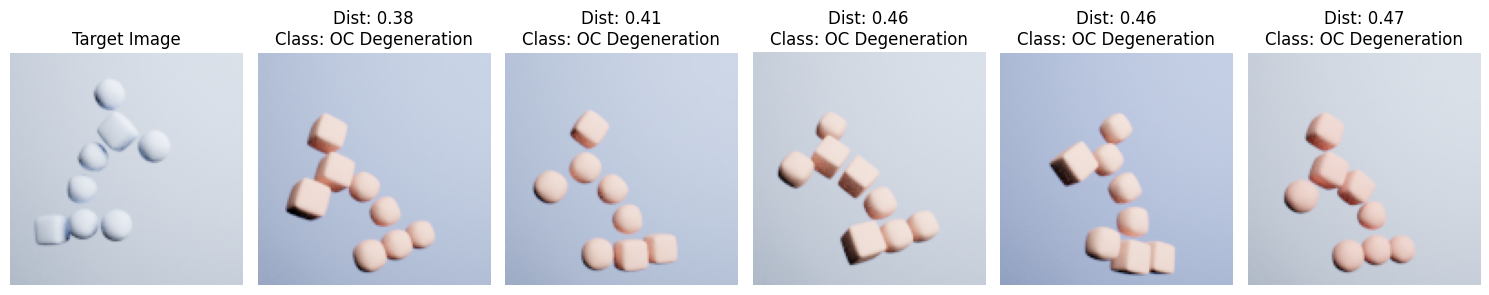

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from PIL import Image

def compute_feature_distances(target_features, dataset_features):
    """
    Compute distances between target features and all dataset examples.
    """
    distances = euclidean_distances(target_features.reshape(1, -1), dataset_features)
    return distances.flatten()

def get_closest_examples(target_features, dataset_df, feature_columns, N=5):
    """
    Find the closest N examples to the target features based on specified columns.
    """
    dataset_features = dataset_df[feature_columns].values
    distances = compute_feature_distances(target_features, dataset_features)
    dataset_df['distance'] = distances
    closest_examples = dataset_df.nsmallest(N, 'distance')
    return closest_examples

def visualize_examples_with_predictions(target_image_path, closest_examples, data_dir, model, transform, device, class_names):
    """
    Visualize the target image, the closest examples, and their predicted classes.
    
    Args:
        target_image_path (str): Path to the target image.
        closest_examples (DataFrame): DataFrame containing the closest examples.
        data_dir (Path): Directory containing the image data.
        model (torch.nn.Module): Trained model for prediction.
        transform (torchvision.transforms.Compose): Transformations to apply to images.
        device (torch.device): Device to use (CPU or GPU).
        class_names (list): List of class names corresponding to model outputs.
    """
    # Load the target image
    target_image = Image.open(target_image_path).convert('RGB')

    # Plot target image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(closest_examples) + 1, 1)
    plt.imshow(target_image)
    plt.title("Target Image")
    plt.axis("off")

    # Predict and plot closest examples
    model.eval()  # Set model to evaluation mode
    for idx, (_, row) in enumerate(closest_examples.iterrows()):  # Fix the index to be sequential
        example_image_path = data_dir / row['filename']
        example_image = Image.open(example_image_path).convert('RGB')

        # Transform and prepare the example image for prediction
        input_tensor = transform(example_image).unsqueeze(0).to(device)
        
        # Get model prediction
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = class_names[output.argmax(dim=1).item()]

        # Plot the image with prediction and distance
        plt.subplot(1, len(closest_examples) + 1, idx + 2)
        plt.imshow(example_image)
        plt.title(f"Dist: {row['distance']:.2f}\nClass: {predicted_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




# Specify feature columns
feature_columns = [
    'ill_spherical', 'num_diff', 'bending', 'obj_rotation_roll', 
    'obj_rotation_pitch', 'obj_rotation_yaw', 'fliplr', 
    'position_x', 'position_y', 'arm_position', 'obj_color', 'bg_color'
]

# Example usage
target_image_path = str(ds_dir / 'test' / test_df.iloc[0]['filename'])  # Path to target image
target_features = test_df.iloc[0][feature_columns].values  # Features of target image

# Get closest examples
N = 5  # Number of closest examples to retrieve
closest_examples = get_closest_examples(target_features, train_df, feature_columns, N)

# Visualize results
# Example usage
visualize_examples_with_predictions(
    target_image_path=image_path,
    closest_examples=closest_examples,
    data_dir=ds_dir / 'train',
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES
)

